
🔄 loop_node, progress = 0

🔄 loop_node, progress = 30

🔄 loop_node, progress = 60

🔄 loop_node, progress = 90

🔹 final_node
{'user_query': 'test', 'intent': '', 'result': '', 'progress': 100}


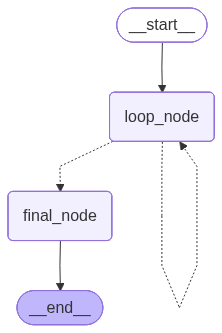

In [ ]:
# ================== 基础依赖 ==================
from typing import TypedDict, NotRequired
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import PromptTemplate
from langgraph.checkpoint.memory import MemorySaver

# DeepSeek LLM（真实模型）
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 加载环境变量
load_dotenv()

# 初始化真实 LLM
llm = ChatOpenAI(
    api_key=os.getenv("API_KEY"),
    base_url="https://api.deepseek.com",
    model="deepseek-chat",
    temperature=0.3
)

# ==========================================================
# 1. 定义 State（工作流共享状态 = Agent 内存）
# ==========================================================
class TextProcessState(TypedDict):
    """
    LangGraph 状态对象：
    用于在节点之间传递数据（类似全局共享内存）
    """
    raw_text: str                        # 输入：用户原始文本
    deduplicated_text: NotRequired[str]  # 过程：去重后的文本
    summary_text: NotRequired[str]       # 过程：LLM 生成摘要
    has_sensitive: NotRequired[bool]     # 过程：敏感词检测结果
    final_output: NotRequired[str]       # 输出：最终格式化结果


# ==========================================================
# 2. 定义节点函数（每个节点 = 一个处理模块）
# ==========================================================
def deduplicate_node(state: TextProcessState) -> TextProcessState:
    """文本去重节点"""
    raw_text = state["raw_text"]
    lines = raw_text.split("\n")
    unique_lines = []
    seen = set()
    for line in lines:
        line_stripped = line.strip()
        if line_stripped and line_stripped not in seen:
            seen.add(line_stripped)
            unique_lines.append(line)
    print("✅ 去重节点执行完成")
    return {"deduplicated_text": "\n".join(unique_lines)}

def summary_node(state: TextProcessState) -> TextProcessState:
    """摘要生成节点（调用LLM）"""
    deduplicated_text = state["deduplicated_text"]
    prompt = PromptTemplate(
        input_variables=["text"],
        template="请为以下文本生成50字以内的简洁摘要，保留核心信息：\n{text}"
    )
    chain = prompt | llm
    summary = chain.invoke({"text": deduplicated_text}).content
    print("🤖 摘要节点执行完成")
    return {"summary_text": summary}

def sensitive_check_node(state: TextProcessState) -> TextProcessState:
    """敏感词检测节点"""
    summary = state["summary_text"]
    sensitive_words = ["敏感词1", "敏感词2", "违法", "违规"]
    has_sensitive = any(word in summary for word in sensitive_words)
    print("🔍 敏感词检测完成：", has_sensitive)
    return {"has_sensitive": has_sensitive}

def output_node(state: TextProcessState) -> TextProcessState:
    """输出节点（根据敏感词结果格式化）"""
    summary = state["summary_text"]
    has_sensitive = state["has_sensitive"]
    if has_sensitive:
        final_output = "⚠️ 检测到敏感内容，无法输出摘要"
    else:
        final_output = f"""✅ 文本处理完成
【摘要】
{summary}

【去重后原文】
{state['deduplicated_text']}
"""
    print("📤 输出节点执行完成")
    return {"final_output": final_output}


# ==========================================================
# 3. 构建线性工作流图（固定边）
# ==========================================================
def build_linear_graph():
    """构建线性 LangGraph 工作流，**实际启用状态历史**"""
    graph_builder = StateGraph(TextProcessState)

    # 注册节点
    graph_builder.add_node("deduplicate", deduplicate_node)
    graph_builder.add_node("summary", summary_node)
    graph_builder.add_node("sensitive_check", sensitive_check_node)
    graph_builder.add_node("output", output_node)

    # 配置固定边（线性执行）
    graph_builder.add_edge(START, "deduplicate")
    graph_builder.add_edge("deduplicate", "summary")
    graph_builder.add_edge("summary", "sensitive_check")
    graph_builder.add_edge("sensitive_check", "output")
    graph_builder.add_edge("output", END)

    # 【修改核心】编译时传入MemorySaver，真正启用状态历史
    # MemorySaver：内存级检查点，适合测试/开发，重启程序后状态丢失
    return graph_builder.compile(checkpointer=MemorySaver())


# ==========================================================
# 4. 测试运行（get_state_history 可正常使用）
# ==========================================================
if __name__ == "__main__":

    # 构建图
    linear_graph = build_linear_graph()

    # 初始状态（输入数据）
    test_state: TextProcessState = {
        "raw_text": "LangGraph是LangChain生态的工作流框架\nLangGraph支持状态管理\nLangGraph是LangChain生态的工作流框架\n支持动态分支和并行执行"
    }

    # thread_id：会话唯一标识，测试用随便命名，多会话用不同id即可
    config = {"configurable": {"thread_id": "text_process_test_001"}}

    # ========== 关键修改2：invoke时传入config ==========
    final_state = linear_graph.invoke(test_state, config=config)

    # 输出最终结果
    print("\n" + "=" * 50)
    print(final_state["final_output"])

    # ========== 关键修改3：get_state_history时也传入同一个config ==========
    print("\n" + "=" * 50)
    history = list(linear_graph.get_state_history(config))   # 必须传config
    print("状态快照数量（超步骤）：", len(history))

    for i, state in enumerate(history, 1):
        print(f"\n第{i}步：")
        print("state", state)
    

from IPython.display import Image, display
display(Image(linear_graph.get_graph().draw_mermaid_png()))